### 20190313 Agenda

* homework 1: load stock_list.csv
* mpl_finance & seaborn
* technical analysis
* backtrader or pyalgotrade
* numpy & scipy

#### homework 1
* Download the example list [stock10.csv](https://www.csie.ntu.edu.tw/~d00922011/python/data/stock10.csv).
* You can try the upgraded program [twse_crawl.py](https://www.csie.ntu.edu.tw/~d00922011/python/program/twse_crawl.py).

In [1]:
import csv

def load(filename):
    
    print("Load {}...".format(filename))
    with open(filename, "r") as f:
        reader = csv.reader(f)
        output = []
        for row in reader:
            output.append(row[0])
    return output

In [2]:
load ("stock10.csv")

Load stock10.csv...


['1303',
 '2002',
 '2303',
 '2330',
 '2881',
 '1301',
 '2324',
 '2409',
 '2880',
 '2882']

#### mpl_finance & seaborn
* To install mpl_finance, type the following instruction in the terminal:<br>
```pip install mpl_finance```
* Read the document of [matplotlib.finance](https://matplotlib.org/api/finance_api.html).
* Try [mpl_finance_demo.py](https://www.csie.ntu.edu.tw/~d00922011/python/program/mpl_finance_demo.py).

In [3]:
import seaborn as sns
import numpy as np

data = np.random.random([100, 2])

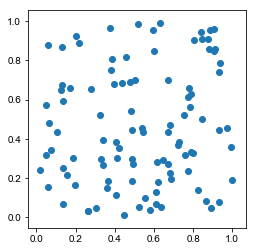

In [4]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1])
sns.set(style = "darkgrid")
plt.axis("square")
plt.show()

#### technical analysis
* See [Technical Analysis Library in Python](https://github.com/bukosabino/ta).
    * Type the following instruction to install ta:<br>
    ```pip install ta```
* Read the document of ta [here](https://technical-analysis-library-in-python.readthedocs.io/en/latest/).

In [5]:
# load 2330.csv

import pandas as pd

headers = ["Date", "Share Volume", "Value Volume", "Open", "High", "Low", "Close", "High-Low", "Trades"]
df = pd.read_csv("2330.csv", names = headers)
df['Date'] =pd.to_datetime(df.Date)
df.sort_values(by = "Date", inplace = True, ascending = True)
df.set_index("Date", inplace = True)

Text(0,0.5,'Price')

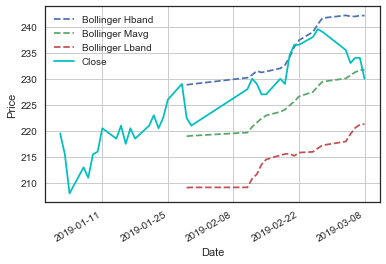

In [6]:
import ta

sns.set(style = "white")

df['Bollinger Hband'] = ta.bollinger_hband(df["Close"])
df['Bollinger Mavg'] = ta.bollinger_mavg(df["Close"])
df['Bollinger Lband'] = ta.bollinger_lband(df["Close"])

df['Bollinger Hband'].plot.line(linestyle = "--")
df['Bollinger Mavg'].plot.line(linestyle = "--")
df['Bollinger Lband'].plot.line(linestyle = "--")
df['Close'].plot.line(color = "c")
plt.legend()
plt.grid()
plt.ylabel("Price")

#### backtrader & pyalgotrade
* See the introduction of backtrader [here]
(https://www.backtrader.com/docu/introduction.html).
    * Type the following instruction to install ta:<br>
    ```pip install backtrader```
* Overview
    * Data feed: financial time series (open, high, low, close, volume)
    * Strategy
    * Broker (executor)
    * Indicator

In [7]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
import datetime

cerebro = bt.Cerebro()
data = bt.feeds.GenericCSVData(dataname = "dj_daily_close.csv",
                               dtformat = ('%Y-%m-%d'),
                               datetime = 0,
                               open = 1,
                               high = 2,
                               low = 3,
                               close = 4,
                               volume = 5)
cerebro.adddata(data)

In [8]:
class MyStrategy(bt.Strategy):

    def log(self, txt, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):

        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add MovingAverageSimple indicators
        self.sma5 = bt.indicators.SimpleMovingAverage(self.datas[-1], period = 5)
        self.sma10 = bt.indicators.SimpleMovingAverage(self.datas[-1], period = 10)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Rejected]:
            self.log('Order Canceled/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    
    def next(self):
        
        self.log('close price, %.2f' % self.dataclose[0])

        if self.order:
            return
        
        if self.sma5 > self.sma10 and self.data.close[0] < self.data.close[-1]:
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.order = self.buy()
            
        elif self.data.close[0] < self.data.close[-1]:
            self.log('CLOSE LONG POSITION, %.2f' % self.dataclose[0])
            self.order = self.close()

cerebro.addstrategy(MyStrategy)

0

In [9]:
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission = 0.0015)
cerebro.addsizer(bt.sizers.SizerFix, stake = 2)

In [10]:
print("Initial portfolio value:", cerebro.broker.getvalue())
cerebro.run()
print("Final portfolio value:", cerebro.broker.getvalue())

Initial portfolio value: 100000.0
1985-02-11, close price, 1276.06
1985-02-11, CLOSE LONG POSITION, 1276.06
1985-02-12, close price, 1276.61
1985-02-13, close price, 1297.92
1985-02-14, close price, 1287.88
1985-02-14, BUY CREATE, 1287.88
1985-02-15, BUY EXECUTED, Price: 1289.20, Cost: 2578.40, Comm 3.87
1985-02-15, close price, 1282.02
1985-02-15, CLOSE LONG POSITION, 1282.02
1985-02-19, SELL EXECUTED, Price: 1279.81, Cost: 2578.40, Comm 3.84
1985-02-19, OPERATION PROFIT, GROSS -18.78, NET -26.49
1985-02-19, close price, 1280.59
1985-02-19, BUY CREATE, 1280.59
1985-02-20, BUY EXECUTED, Price: 1280.15, Cost: 2560.30, Comm 3.84
1985-02-20, close price, 1283.13
1985-02-21, close price, 1279.04
1985-02-21, CLOSE LONG POSITION, 1279.04
1985-02-22, SELL EXECUTED, Price: 1277.94, Cost: 2560.30, Comm 3.83
1985-02-22, OPERATION PROFIT, GROSS -4.42, NET -12.09
1985-02-22, close price, 1275.84
1985-02-22, CLOSE LONG POSITION, 1275.84
1985-02-25, close price, 1277.50
1985-02-26, close price, 1286

1986-07-31, CLOSE LONG POSITION, 1775.31
1986-08-01, SELL EXECUTED, Price: 1775.31, Cost: 10690.38, Comm 15.98
1986-08-01, OPERATION PROFIT, GROSS -38.52, NET -70.53
1986-08-01, close price, 1763.64
1986-08-01, CLOSE LONG POSITION, 1763.64
1986-08-04, close price, 1769.97
1986-08-05, close price, 1777.00
1986-08-06, close price, 1779.53
1986-08-07, close price, 1786.28
1986-08-08, close price, 1782.62
1986-08-08, BUY CREATE, 1782.62
1986-08-11, BUY EXECUTED, Price: 1786.70, Cost: 3573.40, Comm 5.36
1986-08-11, close price, 1811.16
1986-08-12, close price, 1835.49
1986-08-13, close price, 1844.49
1986-08-14, close price, 1844.91
1986-08-15, close price, 1855.60
1986-08-18, close price, 1869.52
1986-08-19, close price, 1862.91
1986-08-19, BUY CREATE, 1862.91
1986-08-20, BUY EXECUTED, Price: 1861.22, Cost: 3722.44, Comm 5.58
1986-08-20, close price, 1881.33
1986-08-21, close price, 1881.19
1986-08-21, BUY CREATE, 1881.19
1986-08-22, BUY EXECUTED, Price: 1879.78, Cost: 3759.56, Comm 5.64
1

1987-06-03, BUY EXECUTED, Price: 2292.17, Cost: 4584.34, Comm 6.88
1987-06-03, close price, 2320.69
1987-06-04, close price, 2337.08
1987-06-05, close price, 2326.15
1987-06-05, BUY CREATE, 2326.15
1987-06-08, BUY EXECUTED, Price: 2320.39, Cost: 4640.78, Comm 6.96
1987-06-08, close price, 2351.64
1987-06-09, close price, 2352.70
1987-06-10, close price, 2353.61
1987-06-11, close price, 2360.13
1987-06-12, close price, 2377.73
1987-06-15, close price, 2391.54
1987-06-16, close price, 2407.35
1987-06-17, close price, 2407.35
1987-06-18, close price, 2408.13
1987-06-19, close price, 2420.85
1987-06-22, close price, 2445.51
1987-06-23, close price, 2439.73
1987-06-23, BUY CREATE, 2439.73
1987-06-24, BUY EXECUTED, Price: 2431.28, Cost: 4862.56, Comm 7.29
1987-06-24, close price, 2428.41
1987-06-24, BUY CREATE, 2428.41
1987-06-25, BUY EXECUTED, Price: 2438.46, Cost: 4876.92, Comm 7.32
1987-06-25, close price, 2451.05
1987-06-26, close price, 2436.86
1987-06-26, BUY CREATE, 2436.86
1987-06-29

1988-03-11, close price, 2034.98
1988-03-14, close price, 2050.07
1988-03-15, close price, 2047.41
1988-03-15, CLOSE LONG POSITION, 2047.41
1988-03-16, close price, 2064.32
1988-03-17, close price, 2086.04
1988-03-18, close price, 2087.37
1988-03-21, close price, 2067.14
1988-03-21, BUY CREATE, 2067.14
1988-03-22, BUY EXECUTED, Price: 2068.13, Cost: 4136.26, Comm 6.20
1988-03-22, close price, 2066.15
1988-03-22, BUY CREATE, 2066.15
1988-03-23, BUY EXECUTED, Price: 2064.98, Cost: 4129.96, Comm 6.19
1988-03-23, close price, 2067.64
1988-03-24, close price, 2023.87
1988-03-24, BUY CREATE, 2023.87
1988-03-25, BUY EXECUTED, Price: 2018.73, Cost: 4037.46, Comm 6.06
1988-03-25, close price, 1978.95
1988-03-25, CLOSE LONG POSITION, 1978.95
1988-03-28, SELL EXECUTED, Price: 1962.37, Cost: 12303.68, Comm 17.66
1988-03-28, OPERATION PROFIT, GROSS -529.46, NET -565.58
1988-03-28, close price, 1979.77
1988-03-29, close price, 1998.34
1988-03-30, close price, 1978.12
1988-03-30, CLOSE LONG POSITION,

1989-04-11, BUY EXECUTED, Price: 2304.43, Cost: 4608.86, Comm 6.91
1989-04-11, close price, 2311.58
1989-04-12, close price, 2319.65
1989-04-13, close price, 2296.00
1989-04-13, BUY CREATE, 2296.00
1989-04-14, BUY EXECUTED, Price: 2319.83, Cost: 4639.66, Comm 6.96
1989-04-14, close price, 2337.06
1989-04-17, close price, 2337.79
1989-04-18, close price, 2379.40
1989-04-19, close price, 2386.91
1989-04-20, close price, 2377.38
1989-04-20, BUY CREATE, 2377.38
1989-04-21, BUY EXECUTED, Price: 2383.43, Cost: 4766.86, Comm 7.15
1989-04-21, close price, 2409.46
1989-04-24, close price, 2402.68
1989-04-24, BUY CREATE, 2402.68
1989-04-25, BUY EXECUTED, Price: 2407.80, Cost: 4815.60, Comm 7.22
1989-04-25, close price, 2386.85
1989-04-25, BUY CREATE, 2386.85
1989-04-26, BUY EXECUTED, Price: 2392.59, Cost: 4785.18, Comm 7.18
1989-04-26, close price, 2389.10
1989-04-27, close price, 2418.99
1989-04-28, close price, 2418.80
1989-04-28, BUY CREATE, 2418.80
1989-05-01, BUY EXECUTED, Price: 2402.49, C

1990-05-14, close price, 2821.53
1990-05-15, close price, 2822.45
1990-05-16, close price, 2819.68
1990-05-16, BUY CREATE, 2819.68
1990-05-17, BUY EXECUTED, Price: 2825.93, Cost: 5651.86, Comm 8.48
1990-05-17, close price, 2831.71
1990-05-18, close price, 2819.91
1990-05-18, BUY CREATE, 2819.91
1990-05-21, BUY EXECUTED, Price: 2811.80, Cost: 5623.60, Comm 8.44
1990-05-21, close price, 2844.68
1990-05-22, close price, 2852.23
1990-05-23, close price, 2856.26
1990-05-24, close price, 2855.55
1990-05-24, BUY CREATE, 2855.55
1990-05-25, BUY EXECUTED, Price: 2838.95, Cost: 5677.90, Comm 8.52
1990-05-25, close price, 2820.92
1990-05-25, BUY CREATE, 2820.92
1990-05-29, BUY EXECUTED, Price: 2816.65, Cost: 5633.30, Comm 8.45
1990-05-29, close price, 2870.49
1990-05-30, close price, 2878.56
1990-05-31, close price, 2876.66
1990-05-31, BUY CREATE, 2876.66
1990-06-01, BUY EXECUTED, Price: 2900.97, Cost: 5801.94, Comm 8.70
1990-06-01, close price, 2900.97
1990-06-04, close price, 2935.19
1990-06-05

1991-06-10, CLOSE LONG POSITION, 2975.40
1991-06-11, SELL EXECUTED, Price: 2980.32, Cost: 29780.84, Comm 44.70
1991-06-11, OPERATION PROFIT, GROSS 22.36, NET -67.02
1991-06-11, close price, 2985.91
1991-06-12, close price, 2961.99
1991-06-12, CLOSE LONG POSITION, 2961.99
1991-06-13, close price, 2965.12
1991-06-14, close price, 3000.45
1991-06-17, close price, 2993.96
1991-06-17, CLOSE LONG POSITION, 2993.96
1991-06-18, close price, 2986.81
1991-06-18, CLOSE LONG POSITION, 2986.81
1991-06-19, close price, 2955.50
1991-06-19, BUY CREATE, 2955.50
1991-06-20, BUY EXECUTED, Price: 2943.65, Cost: 5887.30, Comm 8.83
1991-06-20, close price, 2953.94
1991-06-20, BUY CREATE, 2953.94
1991-06-21, BUY EXECUTED, Price: 2953.71, Cost: 5907.42, Comm 8.86
1991-06-21, close price, 2965.56
1991-06-24, close price, 2913.01
1991-06-24, CLOSE LONG POSITION, 2913.01
1991-06-25, SELL EXECUTED, Price: 2925.54, Cost: 11794.72, Comm 17.55
1991-06-25, OPERATION PROFIT, GROSS -92.56, NET -127.80
1991-06-25, close

1992-06-18, CLOSE LONG POSITION, 3274.10
1992-06-19, close price, 3285.40
1992-06-22, close price, 3280.80
1992-06-22, CLOSE LONG POSITION, 3280.80
1992-06-23, close price, 3285.60
1992-06-24, close price, 3290.70
1992-06-25, close price, 3284.00
1992-06-25, CLOSE LONG POSITION, 3284.00
1992-06-26, close price, 3282.40
1992-06-26, CLOSE LONG POSITION, 3282.40
1992-06-29, close price, 3319.86
1992-06-30, close price, 3318.50
1992-06-30, BUY CREATE, 3318.50
1992-07-01, BUY EXECUTED, Price: 3318.80, Cost: 6637.60, Comm 9.96
1992-07-01, close price, 3354.10
1992-07-02, close price, 3330.30
1992-07-02, BUY CREATE, 3330.30
1992-07-06, BUY EXECUTED, Price: 3330.30, Cost: 6660.60, Comm 9.99
1992-07-06, close price, 3339.20
1992-07-07, close price, 3295.20
1992-07-07, BUY CREATE, 3295.20
1992-07-08, BUY EXECUTED, Price: 3295.20, Cost: 6590.40, Comm 9.89
1992-07-08, close price, 3293.30
1992-07-08, BUY CREATE, 3293.30
1992-07-09, BUY EXECUTED, Price: 3293.60, Cost: 6587.20, Comm 9.88
1992-07-09,

1993-06-22, close price, 3497.53
1993-06-22, BUY CREATE, 3497.53
1993-06-23, BUY EXECUTED, Price: 3497.50, Cost: 6995.00, Comm 10.49
1993-06-23, close price, 3466.81
1993-06-23, CLOSE LONG POSITION, 3466.81
1993-06-24, SELL EXECUTED, Price: 3466.80, Cost: 6995.00, Comm 10.40
1993-06-24, OPERATION PROFIT, GROSS -61.40, NET -82.29
1993-06-24, close price, 3490.61
1993-06-25, close price, 3490.89
1993-06-28, close price, 3530.20
1993-06-29, close price, 3518.85
1993-06-29, CLOSE LONG POSITION, 3518.85
1993-06-30, close price, 3516.08
1993-06-30, BUY CREATE, 3516.08
1993-07-01, BUY EXECUTED, Price: 3516.10, Cost: 7032.20, Comm 10.55
1993-07-01, close price, 3510.54
1993-07-01, BUY CREATE, 3510.54
1993-07-02, BUY EXECUTED, Price: 3510.50, Cost: 7021.00, Comm 10.53
1993-07-02, close price, 3483.97
1993-07-02, BUY CREATE, 3483.97
1993-07-06, BUY EXECUTED, Price: 3484.00, Cost: 6968.00, Comm 10.45
1993-07-06, close price, 3449.93
1993-07-06, BUY CREATE, 3449.93
1993-07-07, BUY EXECUTED, Price:

1994-05-10, SELL EXECUTED, Price: 3629.34, Cost: 36861.54, Comm 54.44
1994-05-10, OPERATION PROFIT, GROSS -568.14, NET -677.87
1994-05-10, close price, 3656.41
1994-05-11, close price, 3629.04
1994-05-11, CLOSE LONG POSITION, 3629.04
1994-05-12, close price, 3652.84
1994-05-13, close price, 3659.68
1994-05-16, close price, 3671.50
1994-05-17, close price, 3720.61
1994-05-18, close price, 3732.89
1994-05-19, close price, 3758.98
1994-05-20, close price, 3766.35
1994-05-23, close price, 3742.41
1994-05-23, BUY CREATE, 3742.41
1994-05-24, BUY EXECUTED, Price: 3742.40, Cost: 7484.80, Comm 11.23
1994-05-24, close price, 3745.17
1994-05-25, close price, 3755.30
1994-05-26, close price, 3753.46
1994-05-26, BUY CREATE, 3753.46
1994-05-27, BUY EXECUTED, Price: 3753.50, Cost: 7507.00, Comm 11.26
1994-05-27, close price, 3757.14
1994-05-31, close price, 3758.37
1994-06-01, close price, 3760.83
1994-06-02, close price, 3758.99
1994-06-02, BUY CREATE, 3758.99
1994-06-03, BUY EXECUTED, Price: 3759.0

1995-03-08, SELL EXECUTED, Price: 3962.60, Cost: 55444.60, Comm 83.21
1995-03-08, OPERATION PROFIT, GROSS 31.80, NET -134.58
1995-03-08, close price, 3979.23
1995-03-09, close price, 3983.39
1995-03-10, close price, 4035.61
1995-03-13, close price, 4025.23
1995-03-13, BUY CREATE, 4025.23
1995-03-14, BUY EXECUTED, Price: 4025.60, Cost: 8051.20, Comm 12.08
1995-03-14, close price, 4048.75
1995-03-15, close price, 4038.37
1995-03-15, BUY CREATE, 4038.37
1995-03-16, BUY EXECUTED, Price: 4038.40, Cost: 8076.80, Comm 12.12
1995-03-16, close price, 4069.15
1995-03-17, close price, 4073.65
1995-03-20, close price, 4083.68
1995-03-21, close price, 4072.61
1995-03-21, BUY CREATE, 4072.61
1995-03-22, BUY EXECUTED, Price: 4072.60, Cost: 8145.20, Comm 12.22
1995-03-22, close price, 4082.99
1995-03-23, close price, 4087.83
1995-03-24, close price, 4138.67
1995-03-27, close price, 4157.34
1995-03-28, close price, 4151.81
1995-03-28, BUY CREATE, 4151.81
1995-03-29, BUY EXECUTED, Price: 4151.80, Cost: 

1996-03-11, BUY EXECUTED, Price: 5470.80, Cost: 10941.60, Comm 16.41
1996-03-11, close price, 5581.00
1996-03-12, close price, 5583.89
1996-03-13, close price, 5568.72
1996-03-13, CLOSE LONG POSITION, 5568.72
1996-03-14, SELL EXECUTED, Price: 5569.10, Cost: 55286.00, Comm 83.54
1996-03-14, OPERATION PROFIT, GROSS 405.00, NET 238.54
1996-03-14, close price, 5586.06
1996-03-15, close price, 5584.97
1996-03-15, CLOSE LONG POSITION, 5584.97
1996-03-18, close price, 5683.60
1996-03-19, close price, 5669.51
1996-03-19, BUY CREATE, 5669.51
1996-03-20, BUY EXECUTED, Price: 5668.80, Cost: 11337.60, Comm 17.01
1996-03-20, close price, 5655.42
1996-03-20, BUY CREATE, 5655.42
1996-03-21, BUY EXECUTED, Price: 5652.20, Cost: 11304.40, Comm 16.96
1996-03-21, close price, 5626.88
1996-03-21, BUY CREATE, 5626.88
1996-03-22, BUY EXECUTED, Price: 5628.30, Cost: 11256.60, Comm 16.88
1996-03-22, close price, 5636.64
1996-03-25, close price, 5643.86
1996-03-26, close price, 5670.60
1996-03-27, close price, 

1997-05-27, close price, 7383.40
1997-05-28, close price, 7357.20
1997-05-28, BUY CREATE, 7357.20
1997-05-29, BUY EXECUTED, Price: 7351.70, Cost: 14703.40, Comm 22.06
1997-05-29, close price, 7330.20
1997-05-29, BUY CREATE, 7330.20
1997-05-30, BUY EXECUTED, Price: 7327.60, Cost: 14655.20, Comm 21.98
1997-05-30, close price, 7331.00
1997-06-02, close price, 7289.40
1997-06-02, BUY CREATE, 7289.40
1997-06-03, BUY EXECUTED, Price: 7287.30, Cost: 14574.60, Comm 21.86
1997-06-03, close price, 7312.10
1997-06-04, close price, 7269.70
1997-06-04, CLOSE LONG POSITION, 7269.70
1997-06-05, SELL EXECUTED, Price: 7269.70, Cost: 43933.20, Comm 65.43
1997-06-05, OPERATION PROFIT, GROSS -315.00, NET -446.33
1997-06-05, close price, 7305.30
1997-06-06, close price, 7435.80
1997-06-09, close price, 7478.50
1997-06-10, close price, 7539.27
1997-06-11, close price, 7575.80
1997-06-12, close price, 7711.50
1997-06-13, close price, 7782.00
1997-06-16, close price, 7772.10
1997-06-16, BUY CREATE, 7772.10
19

1998-09-18, BUY EXECUTED, Price: 7876.35, Cost: 15752.70, Comm 23.63
1998-09-18, close price, 7895.66
1998-09-21, close price, 7933.25
1998-09-22, close price, 7897.20
1998-09-22, BUY CREATE, 7897.20
1998-09-23, BUY EXECUTED, Price: 7897.20, Cost: 15794.40, Comm 23.69
1998-09-23, close price, 8154.41
1998-09-24, close price, 8001.99
1998-09-24, BUY CREATE, 8001.99
1998-09-25, BUY EXECUTED, Price: 8001.99, Cost: 16003.98, Comm 24.01
1998-09-25, close price, 8028.77
1998-09-28, close price, 8108.84
1998-09-29, close price, 8080.52
1998-09-29, BUY CREATE, 8080.52
1998-09-30, BUY EXECUTED, Price: 8079.49, Cost: 16158.98, Comm 24.24
1998-09-30, close price, 7842.62
1998-09-30, BUY CREATE, 7842.62
1998-10-01, BUY EXECUTED, Price: 7841.33, Cost: 15682.66, Comm 23.52
1998-10-01, close price, 7632.53
1998-10-01, CLOSE LONG POSITION, 7632.53
1998-10-02, SELL EXECUTED, Price: 7631.24, Cost: 79392.72, Comm 114.47
1998-10-02, OPERATION PROFIT, GROSS -3080.32, NET -3313.88
1998-10-02, close price, 7

1999-11-22, close price, 11089.52
1999-11-23, close price, 10995.63
1999-11-23, BUY CREATE, 10995.63
1999-11-24, close price, 11008.17
1999-11-26, close price, 10988.91
1999-11-26, BUY CREATE, 10988.91
1999-11-29, close price, 10947.92
1999-11-29, BUY CREATE, 10947.92
1999-11-30, close price, 10877.81
1999-11-30, CLOSE LONG POSITION, 10877.81
1999-12-01, SELL EXECUTED, Price: 10876.47, Cost: 83779.78, Comm 130.52
1999-12-01, OPERATION PROFIT, GROSS 3231.98, NET 2975.79
1999-12-01, close price, 10998.39
1999-12-02, close price, 11039.06
1999-12-03, close price, 11286.18
1999-12-06, close price, 11225.01
1999-12-06, BUY CREATE, 11225.01
1999-12-07, BUY EXECUTED, Price: 11221.65, Cost: 22443.30, Comm 33.66
1999-12-07, close price, 11106.65
1999-12-07, BUY CREATE, 11106.65
1999-12-08, BUY EXECUTED, Price: 11107.26, Cost: 22214.52, Comm 33.32
1999-12-08, close price, 11068.12
1999-12-08, BUY CREATE, 11068.12
1999-12-09, BUY EXECUTED, Price: 11073.62, Cost: 22147.24, Comm 33.22
1999-12-09, c

2001-02-14, OPERATION PROFIT, GROSS 1679.56, NET 1420.49
2001-02-14, close price, 10795.41
2001-02-14, CLOSE LONG POSITION, 10795.41
2001-02-15, close price, 10891.02
2001-02-16, close price, 10799.82
2001-02-16, CLOSE LONG POSITION, 10799.82
2001-02-20, close price, 10730.88
2001-02-20, CLOSE LONG POSITION, 10730.88
2001-02-21, close price, 10526.58
2001-02-21, CLOSE LONG POSITION, 10526.58
2001-02-22, close price, 10526.81
2001-02-23, close price, 10441.90
2001-02-23, CLOSE LONG POSITION, 10441.90
2001-02-26, close price, 10642.53
2001-02-27, close price, 10636.88
2001-02-27, CLOSE LONG POSITION, 10636.88
2001-02-28, close price, 10495.28
2001-02-28, CLOSE LONG POSITION, 10495.28
2001-03-01, close price, 10450.14
2001-03-01, CLOSE LONG POSITION, 10450.14
2001-03-02, close price, 10466.31
2001-03-05, close price, 10562.30
2001-03-06, close price, 10591.22
2001-03-07, close price, 10729.60
2001-03-08, close price, 10858.25
2001-03-09, close price, 10644.62
2001-03-09, BUY CREATE, 10644

2002-07-16, close price, 8473.11
2002-07-16, CLOSE LONG POSITION, 8473.11
2002-07-17, close price, 8542.48
2002-07-18, close price, 8409.49
2002-07-18, CLOSE LONG POSITION, 8409.49
2002-07-19, close price, 8019.26
2002-07-19, CLOSE LONG POSITION, 8019.26
2002-07-22, close price, 7784.58
2002-07-22, CLOSE LONG POSITION, 7784.58
2002-07-23, close price, 7702.34
2002-07-23, CLOSE LONG POSITION, 7702.34
2002-07-24, close price, 8191.29
2002-07-25, close price, 8186.31
2002-07-25, CLOSE LONG POSITION, 8186.31
2002-07-26, close price, 8264.39
2002-07-29, close price, 8711.88
2002-07-30, close price, 8680.03
2002-07-30, BUY CREATE, 8680.03
2002-07-31, BUY EXECUTED, Price: 8678.65, Cost: 17357.30, Comm 26.04
2002-07-31, close price, 8736.59
2002-08-01, close price, 8506.62
2002-08-01, BUY CREATE, 8506.62
2002-08-02, BUY EXECUTED, Price: 8504.96, Cost: 17009.92, Comm 25.51
2002-08-02, close price, 8313.13
2002-08-02, BUY CREATE, 8313.13
2002-08-05, BUY EXECUTED, Price: 8312.92, Cost: 16625.84, 

2003-08-29, close price, 9415.82
2003-09-02, close price, 9523.27
2003-09-03, close price, 9568.46
2003-09-04, close price, 9587.90
2003-09-05, close price, 9503.34
2003-09-05, BUY CREATE, 9503.34
2003-09-08, BUY EXECUTED, Price: 9503.41, Cost: 19006.82, Comm 28.51
2003-09-08, close price, 9586.29
2003-09-09, close price, 9507.20
2003-09-09, BUY CREATE, 9507.20
2003-09-10, BUY EXECUTED, Price: 9504.88, Cost: 19009.76, Comm 28.51
2003-09-10, close price, 9420.46
2003-09-10, BUY CREATE, 9420.46
2003-09-11, BUY EXECUTED, Price: 9415.05, Cost: 18830.10, Comm 28.25
2003-09-11, close price, 9459.76
2003-09-12, close price, 9471.55
2003-09-15, close price, 9448.81
2003-09-15, CLOSE LONG POSITION, 9448.81
2003-09-16, SELL EXECUTED, Price: 9449.16, Cost: 56846.68, Comm 85.04
2003-09-16, OPERATION PROFIT, GROSS -151.72, NET -322.03
2003-09-16, close price, 9567.34
2003-09-17, close price, 9545.65
2003-09-17, CLOSE LONG POSITION, 9545.65
2003-09-18, close price, 9659.13
2003-09-19, close price, 9

2004-10-20, close price, 9886.93
2004-10-20, CLOSE LONG POSITION, 9886.93
2004-10-21, close price, 9865.76
2004-10-21, CLOSE LONG POSITION, 9865.76
2004-10-22, close price, 9757.81
2004-10-22, CLOSE LONG POSITION, 9757.81
2004-10-25, close price, 9749.99
2004-10-25, CLOSE LONG POSITION, 9749.99
2004-10-26, close price, 9888.48
2004-10-27, close price, 10002.03
2004-10-28, close price, 10004.54
2004-10-29, close price, 10027.47
2004-11-01, close price, 10054.39
2004-11-02, close price, 10035.73
2004-11-02, BUY CREATE, 10035.73
2004-11-03, BUY EXECUTED, Price: 10037.50, Cost: 20075.00, Comm 30.11
2004-11-03, close price, 10137.05
2004-11-04, close price, 10314.76
2004-11-05, close price, 10387.54
2004-11-08, close price, 10391.31
2004-11-09, close price, 10386.37
2004-11-09, BUY CREATE, 10386.37
2004-11-10, BUY EXECUTED, Price: 10378.59, Cost: 20757.18, Comm 31.14
2004-11-10, close price, 10385.48
2004-11-10, BUY CREATE, 10385.48
2004-11-11, BUY EXECUTED, Price: 10386.95, Cost: 20773.90,

2005-12-05, CLOSE LONG POSITION, 10835.01
2005-12-06, SELL EXECUTED, Price: 10835.41, Cost: 63257.12, Comm 97.52
2005-12-06, OPERATION PROFIT, GROSS 1755.34, NET 1562.94
2005-12-06, close price, 10856.86
2005-12-07, close price, 10810.91
2005-12-07, CLOSE LONG POSITION, 10810.91
2005-12-08, close price, 10755.12
2005-12-08, CLOSE LONG POSITION, 10755.12
2005-12-09, close price, 10778.58
2005-12-12, close price, 10767.77
2005-12-12, CLOSE LONG POSITION, 10767.77
2005-12-13, close price, 10823.72
2005-12-14, close price, 10883.51
2005-12-15, close price, 10881.67
2005-12-15, CLOSE LONG POSITION, 10881.67
2005-12-16, close price, 10875.59
2005-12-16, BUY CREATE, 10875.59
2005-12-19, BUY EXECUTED, Price: 10875.51, Cost: 21751.02, Comm 32.63
2005-12-19, close price, 10836.53
2005-12-19, BUY CREATE, 10836.53
2005-12-20, BUY EXECUTED, Price: 10836.93, Cost: 21673.86, Comm 32.51
2005-12-20, close price, 10805.55
2005-12-20, BUY CREATE, 10805.55
2005-12-21, BUY EXECUTED, Price: 10805.63, Cost: 

2007-02-05, close price, 12661.74
2007-02-06, close price, 12666.31
2007-02-07, close price, 12666.87
2007-02-08, close price, 12637.63
2007-02-08, BUY CREATE, 12637.63
2007-02-09, BUY EXECUTED, Price: 12638.03, Cost: 25276.06, Comm 37.91
2007-02-09, close price, 12580.83
2007-02-09, BUY CREATE, 12580.83
2007-02-12, BUY EXECUTED, Price: 12580.11, Cost: 25160.22, Comm 37.74
2007-02-12, close price, 12552.55
2007-02-12, CLOSE LONG POSITION, 12552.55
2007-02-13, SELL EXECUTED, Price: 12549.19, Cost: 75743.10, Comm 112.94
2007-02-13, OPERATION PROFIT, GROSS -447.96, NET -674.52
2007-02-13, close price, 12654.85
2007-02-14, close price, 12741.86
2007-02-15, close price, 12765.01
2007-02-16, close price, 12767.57
2007-02-20, close price, 12786.64
2007-02-21, close price, 12738.41
2007-02-21, BUY CREATE, 12738.41
2007-02-22, BUY EXECUTED, Price: 12735.77, Cost: 25471.54, Comm 38.21
2007-02-22, close price, 12686.02
2007-02-22, BUY CREATE, 12686.02
2007-02-23, BUY EXECUTED, Price: 12679.89, Co

2008-04-10, close price, 12581.98
2008-04-11, close price, 12325.42
2008-04-11, CLOSE LONG POSITION, 12325.42
2008-04-14, SELL EXECUTED, Price: 12324.77, Cost: 74112.20, Comm 110.92
2008-04-14, OPERATION PROFIT, GROSS -163.58, NET -385.67
2008-04-14, close price, 12302.06
2008-04-14, CLOSE LONG POSITION, 12302.06
2008-04-15, close price, 12362.47
2008-04-16, close price, 12619.27
2008-04-17, close price, 12620.49
2008-04-18, close price, 12849.36
2008-04-21, close price, 12825.02
2008-04-21, BUY CREATE, 12825.02
2008-04-22, BUY EXECUTED, Price: 12825.02, Cost: 25650.04, Comm 38.48
2008-04-22, close price, 12720.23
2008-04-22, BUY CREATE, 12720.23
2008-04-23, BUY EXECUTED, Price: 12721.45, Cost: 25442.90, Comm 38.16
2008-04-23, close price, 12763.22
2008-04-24, close price, 12848.95
2008-04-25, close price, 12891.86
2008-04-28, close price, 12871.75
2008-04-28, BUY CREATE, 12871.75
2008-04-29, BUY EXECUTED, Price: 12870.37, Cost: 25740.74, Comm 38.61
2008-04-29, close price, 12831.94
20

2009-05-20, CLOSE LONG POSITION, 8422.04
2009-05-21, close price, 8292.13
2009-05-21, CLOSE LONG POSITION, 8292.13
2009-05-22, close price, 8277.32
2009-05-22, BUY CREATE, 8277.32
2009-05-26, BUY EXECUTED, Price: 8277.32, Cost: 16554.64, Comm 24.83
2009-05-26, close price, 8473.49
2009-05-27, close price, 8300.02
2009-05-27, CLOSE LONG POSITION, 8300.02
2009-05-28, SELL EXECUTED, Price: 8300.50, Cost: 16554.64, Comm 24.90
2009-05-28, OPERATION PROFIT, GROSS 46.36, NET -3.37
2009-05-28, close price, 8403.80
2009-05-29, close price, 8500.33
2009-06-01, close price, 8721.44
2009-06-02, close price, 8740.87
2009-06-03, close price, 8675.24
2009-06-03, BUY CREATE, 8675.24
2009-06-04, BUY EXECUTED, Price: 8675.28, Cost: 17350.56, Comm 26.03
2009-06-04, close price, 8750.24
2009-06-05, close price, 8763.13
2009-06-08, close price, 8764.49
2009-06-09, close price, 8763.06
2009-06-09, BUY CREATE, 8763.06
2009-06-10, BUY EXECUTED, Price: 8763.66, Cost: 17527.32, Comm 26.29
2009-06-10, close pric

2010-08-09, close price, 10698.75
2010-08-10, close price, 10644.25
2010-08-10, BUY CREATE, 10644.25
2010-08-11, close price, 10378.83
2010-08-11, BUY CREATE, 10378.83
2010-08-12, close price, 10319.95
2010-08-12, CLOSE LONG POSITION, 10319.95
2010-08-13, SELL EXECUTED, Price: 10320.33, Cost: 62865.90, Comm 92.88
2010-08-13, OPERATION PROFIT, GROSS -943.92, NET -1131.10
2010-08-13, close price, 10303.15
2010-08-13, CLOSE LONG POSITION, 10303.15
2010-08-16, close price, 10302.01
2010-08-16, CLOSE LONG POSITION, 10302.01
2010-08-17, close price, 10405.85
2010-08-18, close price, 10415.54
2010-08-19, close price, 10271.21
2010-08-19, CLOSE LONG POSITION, 10271.21
2010-08-20, close price, 10213.62
2010-08-20, CLOSE LONG POSITION, 10213.62
2010-08-23, close price, 10174.41
2010-08-23, CLOSE LONG POSITION, 10174.41
2010-08-24, close price, 10040.45
2010-08-24, CLOSE LONG POSITION, 10040.45
2010-08-25, close price, 10060.06
2010-08-26, close price, 9985.81
2010-08-26, CLOSE LONG POSITION, 998

2011-10-26, close price, 11869.04
2011-10-27, close price, 12208.55
2011-10-28, close price, 12231.11
2011-10-31, close price, 11955.01
2011-10-31, BUY CREATE, 11955.01
2011-11-01, close price, 11657.96
2011-11-01, BUY CREATE, 11657.96
2011-11-02, close price, 11836.04
2011-11-03, close price, 12044.47
2011-11-04, close price, 11983.24
2011-11-04, CLOSE LONG POSITION, 11983.24
2011-11-07, SELL EXECUTED, Price: 11983.02, Cost: 68585.00, Comm 107.85
2011-11-07, OPERATION PROFIT, GROSS 3313.12, NET 3102.39
2011-11-07, close price, 12068.39
2011-11-08, close price, 12170.18
2011-11-09, close price, 11780.94
2011-11-09, BUY CREATE, 11780.94
2011-11-10, BUY EXECUTED, Price: 11780.03, Cost: 23560.06, Comm 35.34
2011-11-10, close price, 11893.86
2011-11-11, close price, 12153.68
2011-11-14, close price, 12078.98
2011-11-14, BUY CREATE, 12078.98
2011-11-15, BUY EXECUTED, Price: 12077.92, Cost: 24155.84, Comm 36.23
2011-11-15, close price, 12096.16
2011-11-16, close price, 11905.59
2011-11-16, B

2012-12-20, close price, 13311.72
2012-12-21, close price, 13190.84
2012-12-21, BUY CREATE, 13190.84
2012-12-24, close price, 13138.93
2012-12-24, BUY CREATE, 13138.93
2012-12-26, close price, 13114.59
2012-12-26, CLOSE LONG POSITION, 13114.59
2012-12-27, SELL EXECUTED, Price: 13114.97, Cost: 51677.88, Comm 78.69
2012-12-27, OPERATION PROFIT, GROSS 782.00, NET 625.79
2012-12-27, close price, 13096.31
2012-12-27, CLOSE LONG POSITION, 13096.31
2012-12-28, close price, 12938.11
2012-12-28, CLOSE LONG POSITION, 12938.11
2012-12-31, close price, 13104.14
2013-01-02, close price, 13412.55
2013-01-03, close price, 13391.36
2013-01-03, CLOSE LONG POSITION, 13391.36
2013-01-04, close price, 13435.21
2013-01-07, close price, 13384.29
2013-01-07, BUY CREATE, 13384.29
2013-01-08, BUY EXECUTED, Price: 13377.42, Cost: 26754.84, Comm 40.13
2013-01-08, close price, 13328.85
2013-01-08, BUY CREATE, 13328.85
2013-01-09, BUY EXECUTED, Price: 13329.92, Cost: 26659.84, Comm 39.99
2013-01-09, close price, 1

2014-03-19, close price, 16222.17
2014-03-19, CLOSE LONG POSITION, 16222.17
2014-03-20, close price, 16331.05
2014-03-21, close price, 16302.77
2014-03-21, BUY CREATE, 16302.77
2014-03-24, BUY EXECUTED, Price: 16303.28, Cost: 32606.56, Comm 48.91
2014-03-24, close price, 16276.69
2014-03-24, BUY CREATE, 16276.69
2014-03-25, BUY EXECUTED, Price: 16279.20, Cost: 32558.40, Comm 48.84
2014-03-25, close price, 16367.88
2014-03-26, close price, 16268.99
2014-03-26, BUY CREATE, 16268.99
2014-03-27, close price, 16264.23
2014-03-27, BUY CREATE, 16264.23
2014-03-28, close price, 16323.06
2014-03-31, close price, 16457.66
2014-04-01, close price, 16532.61
2014-04-02, close price, 16573.00
2014-04-03, close price, 16572.55
2014-04-03, BUY CREATE, 16572.55
2014-04-04, close price, 16412.71
2014-04-04, BUY CREATE, 16412.71
2014-04-07, close price, 16245.87
2014-04-07, BUY CREATE, 16245.87
2014-04-08, close price, 16256.14
2014-04-09, close price, 16437.18
2014-04-10, close price, 16170.22
2014-04-1

2015-06-08, CLOSE LONG POSITION, 17766.55
2015-06-09, close price, 17764.04
2015-06-09, CLOSE LONG POSITION, 17764.04
2015-06-10, close price, 18000.40
2015-06-11, close price, 18039.37
2015-06-12, close price, 17898.84
2015-06-12, CLOSE LONG POSITION, 17898.84
2015-06-15, close price, 17791.17
2015-06-15, CLOSE LONG POSITION, 17791.17
2015-06-16, close price, 17904.48
2015-06-17, close price, 17935.74
2015-06-18, close price, 18115.84
2015-06-19, close price, 18015.95
2015-06-19, BUY CREATE, 18015.95
2015-06-22, BUY EXECUTED, Price: 18027.63, Cost: 36055.26, Comm 54.08
2015-06-22, close price, 18119.78
2015-06-23, close price, 18144.07
2015-06-24, close price, 17966.07
2015-06-24, BUY CREATE, 17966.07
2015-06-25, BUY EXECUTED, Price: 17977.11, Cost: 35954.22, Comm 53.93
2015-06-25, close price, 17890.36
2015-06-25, BUY CREATE, 17890.36
2015-06-26, close price, 17946.68
2015-06-29, close price, 17596.35
2015-06-29, CLOSE LONG POSITION, 17596.35
2015-06-30, SELL EXECUTED, Price: 17599.9

2016-08-19, BUY CREATE, 18552.57
2016-08-22, close price, 18529.42
2016-08-22, CLOSE LONG POSITION, 18529.42
2016-08-23, SELL EXECUTED, Price: 18568.94, Cost: 37038.16, Comm 55.71
2016-08-23, OPERATION PROFIT, GROSS 99.72, NET -11.55
2016-08-23, close price, 18547.30
2016-08-24, close price, 18481.48
2016-08-24, CLOSE LONG POSITION, 18481.48
2016-08-25, close price, 18448.41
2016-08-25, CLOSE LONG POSITION, 18448.41
2016-08-26, close price, 18395.40
2016-08-26, CLOSE LONG POSITION, 18395.40
2016-08-29, close price, 18502.99
2016-08-30, close price, 18454.30
2016-08-30, CLOSE LONG POSITION, 18454.30
2016-08-31, close price, 18400.88
2016-08-31, CLOSE LONG POSITION, 18400.88
2016-09-01, close price, 18419.30
2016-09-02, close price, 18491.96
2016-09-06, close price, 18538.12
2016-09-07, close price, 18526.14
2016-09-07, BUY CREATE, 18526.14
2016-09-08, BUY EXECUTED, Price: 18486.69, Cost: 36973.38, Comm 55.46
2016-09-08, close price, 18479.91
2016-09-08, BUY CREATE, 18479.91
2016-09-09, 

2017-11-15, CLOSE LONG POSITION, 23271.28
2017-11-16, close price, 23458.36
2017-11-17, close price, 23358.24
2017-11-17, CLOSE LONG POSITION, 23358.24
2017-11-20, close price, 23430.33
2017-11-21, close price, 23590.83
2017-11-22, close price, 23526.18
2017-11-22, BUY CREATE, 23526.18
2017-11-24, BUY EXECUTED, Price: 23552.75, Cost: 47105.50, Comm 70.66
2017-11-24, close price, 23557.99
2017-11-27, close price, 23580.78
2017-11-28, close price, 23836.71
2017-11-29, close price, 23940.68
2017-11-30, close price, 24272.35
2017-12-01, close price, 24231.59
2017-12-01, BUY CREATE, 24231.59
2017-12-04, close price, 24290.05
2017-12-05, close price, 24180.64
2017-12-05, BUY CREATE, 24180.64
2017-12-06, close price, 24140.91
2017-12-06, BUY CREATE, 24140.91
2017-12-07, close price, 24211.48
2017-12-08, close price, 24329.16
2017-12-11, close price, 24386.03
2017-12-12, close price, 24504.80
2017-12-13, close price, 24585.43
2017-12-14, close price, 24508.66
2017-12-14, BUY CREATE, 24508.66
2

C:\ProgramData\Anaconda3\lib\site-packages\backtrader\plot\__init__.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Progra

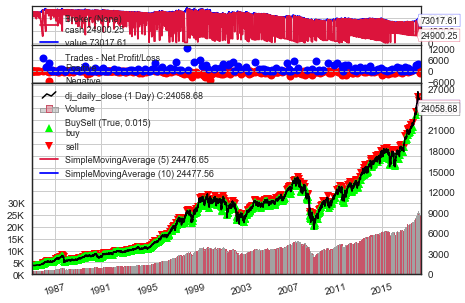

[[<Figure size 432x288 with 4 Axes>]]

In [11]:
cerebro.plot(figsize = (10, 6))

#### numpy & scipy

* numpy
    * vectorization: different from list, similar to matrices in Matlab
    * ndarray creations
        * numpy.array()
        * numpy.arange()
        * numpy.linspace()
        * numpy.ones()
        * numpy.zeros()
        * numpy.eye()
        * numpy.diag()
        * numpy.random.rand()
        * numpy.random.randn()
        * numpy.random.randint()
    * data types: same type in one array
        * dtype: int8, int16, ..., float16, float32, ..., complex64, bool, unicode_
        * numpy.astype()
    * array operations
        * fetch data by slicing, same as list
        * numpy.reshape()
        * numpy.array_equal()
        * numpy.prod()
        * numpy.sum()
        * numpy.mean()
        * numpy.unique()
        * numpy.concatenate()
        * numpy.all()
        * numpy.any()
        * numpy.sort()
    * array properties
        * numpy.ndim
        * numpy.shape
        * numpy.size
        * numpy.T
        * numpy.ravel()
        * numpy.where()

In [12]:
# list

x = [1, 2, 3]
y = [4, 5, 6]
x + y

[1, 2, 3, 4, 5, 6]

In [13]:
# numpy

import numpy as np

print(type(x))
x = np.array(x)
print(type(x))
y = np.array(y)

x + y

<class 'list'>
<class 'numpy.ndarray'>


array([5, 7, 9])

In [14]:
xdata = np.linspace(0, 10, 11)
print(xdata)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [15]:
M = np.zeros([3, 3])
print(M)

M[1, 1] = 5
print(M)

M[2, :] = [10, 20, 30]
print(M)

M[:, 2] = [100, 200, 300]
print(M)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 5. 0.]
 [0. 0. 0.]]
[[ 0.  0.  0.]
 [ 0.  5.  0.]
 [10. 20. 30.]]
[[  0.   0. 100.]
 [  0.   5. 200.]
 [ 10.  20. 300.]]


In [16]:
N = M.reshape(9, 1)
print(N)

[[  0.]
 [  0.]
 [100.]
 [  0.]
 [  5.]
 [200.]
 [ 10.]
 [ 20.]
 [300.]]


In [20]:
import numpy as np

M = np.random.randint(-5, 5, size = (3, 3))
print(M)
print(M.shape)
print(M.ravel())
print(M.T)

x = np.random.randint(-10, 10, size = (3, 1))
print(x)

[[-1  3  4]
 [ 2 -4  4]
 [-4 -5 -4]]
(3, 3)
[-1  3  4  2 -4  4 -4 -5 -4]
[[-1  2 -4]
 [ 3 -4 -5]
 [ 4  4 -4]]
[[ 8]
 [ 9]
 [-2]]


In [21]:
y =  M.dot(x)
print(y)

[[ 11]
 [-28]
 [-69]]


In [22]:
iM = np.linalg.inv(M)
print(iM)

[[-0.2195122   0.04878049 -0.17073171]
 [ 0.04878049 -0.12195122 -0.07317073]
 [ 0.15853659  0.10365854  0.01219512]]


In [23]:
print(M.dot(iM))
print(iM.dot(M))

[[ 1.00000000e+00  0.00000000e+00  4.16333634e-17]
 [ 0.00000000e+00  1.00000000e+00 -4.16333634e-17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00  1.11022302e-16]
 [-5.55111512e-17  1.00000000e+00 -5.55111512e-17]
 [ 1.38777878e-17 -5.55111512e-17  1.00000000e+00]]


In [24]:
# list: *

s = "N"
print(s * 10)

NNNNNNNNNN


In [25]:
# numpy: *

salary = np.array([10, 20, 30])
hours = np.array([100, 50, 10])
payment = salary * hours
print(payment)

[1000 1000  300]


In [26]:
print(np.sum(M))
print(np.sum(M, axis = 0))
print(np.sum(M, axis = 1))

-5
[-3 -6  4]
[  6   2 -13]


In [27]:
# exercise: use ndarray to rewrite the MC program for pi

N = 100000
m = 0
for _ in range(N):
    x = np.random.rand()
    y = np.random.rand()
    if x ** 2 + y ** 2 < 1:
        m += 1
        
print(4 * m / N)

3.14616


In [28]:
x = np.random.rand(1, N)
y = np.random.rand(1, N)
mask = x ** 2 + y ** 2 < 1
print(4 * np.sum(mask) / N)

3.1322
